In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/immo_data_202208_v2.csv', low_memory=False)
df.head()

,Unnamed: 0.1,Unnamed: 0,Municipality,Living space,Plot area,Floor space,Availability,location,description,detailed_description,...,features,description_detailed,Floor space:,Number of floors:,Volume:,plz,Number of toilets:,Gross yield:,Minimum floor space:,space_cleaned
0,0,0,Biberstein,100 m²,NaN,NaN,On request,"5023 Biberstein, AG","3.5 rooms, 100 m²«Luxuriöse Attika-Wohnung mit...",DescriptionLuxuriöse Attika-Wohnung direkt an ...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
1,1,1,Biberstein,156 m²,222 m²,242 m²,On request,"Buhldenstrasse 8d5023 Biberstein, AG","4.5 rooms, 156 m²«Stilvolle Liegenschaft - ruh...",DescriptionStilvolle Liegenschaft an ruhiger L...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
2,2,2,NaN,NaN,NaN,NaN,NaN,"5022 Rombach, AG","2.5 rooms, 93 m²«Moderne, lichtdurchflutete At...","detail_responsive#description_title2,5 Zimmerw...",...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN
3,3,3,Biberstein,154 m²,370 m²,257 m²,On request,"Buhaldenstrasse 8A5023 Biberstein, AG","4.5 rooms, 154 m²«AgentSelly - Luxuriöses Eckh...",DescriptionDieses äusserst grosszügige Minergi...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
4,4,4,Küttigen,142 m²,NaN,NaN,On request,"5022 Rombach, AG","4.5 rooms, 142 m²«MIT GARTENSITZPLATZ UND VIEL...",DescriptionAus ehemals zwei Wohnungen wurde ei...,...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN


# Data Cleaning

In [73]:
df_numeric = df.select_dtypes(include=np.number)
df_numeric

,Unnamed: 0.1,Unnamed: 0,lat,lon,index,ForestDensityL,ForestDensityM,ForestDensityS,Latitude,Longitude,...,Plot_area_unified,Living_area_unified,No. of rooms:,Number of apartments:,Last refurbishment:,Year built:,Number of floors:,plz,Number of toilets:,space_cleaned
0,0,0,47.417100,8.085600,16620,0.511176,0.286451,0.090908,47.415927,8.085840,...,NaN,100.0,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN
1,1,1,47.419500,8.082700,16620,0.511176,0.286451,0.090908,47.415927,8.085840,...,222.0,156.0,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN
2,2,2,47.403300,8.033000,17812,0.163362,0.095877,0.001911,47.397416,8.043150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN
3,3,3,47.415643,8.085423,16620,0.511176,0.286451,0.090908,47.415927,8.085840,...,370.0,154.0,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN
4,4,4,47.403824,8.048288,12716,0.333865,0.279276,0.145835,47.404870,8.052781,...,NaN,142.0,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476,22476,29298,47.158318,9.468165,35362,0.495715,0.385885,0.097278,47.158311,9.468139,...,140.0,102.0,4.5,2.0,2021.0,1920.0,NaN,9470.0,NaN,102.0
22477,22477,29300,47.467488,9.052574,13921,0.000000,0.000000,0.000000,47.467888,9.052650,...,NaN,250.0,8.5,NaN,NaN,2022.0,3.0,9500.0,NaN,180.0
22478,22478,29301,47.465266,9.041548,14127,0.000000,0.000000,0.000000,47.463605,9.038485,...,455.0,240.0,8.5,1.0,2021.0,1966.0,3.0,9500.0,NaN,167.0
22479,22479,29302,47.526504,8.927411,10312,0.410843,0.151363,0.038351,47.526024,8.926627,...,NaN,175.0,5.5,NaN,NaN,2022.0,NaN,9548.0,NaN,175.0


### drop useless columns

In [74]:
df_numeric = df_numeric.drop(['Unnamed: 0.1', 'Unnamed: 0', 'lat', 'lon', 'index', 'Latitude', 'Longitude', 'plz_parsed', 'plz'], axis=1)

In [75]:
# Check for missing values
missing_data = df_numeric.isnull().sum().sort_values(ascending=False)
missing_percentage = (df_numeric.isnull().sum() / df_numeric.shape[0]).sort_values(ascending=False) * 100

# Combine the results into a single DataFrame
missing_df = pd.concat([missing_data, missing_percentage], axis=1, keys=['Total Missing', 'Percentage (%)'])

# Display columns with missing data
missing_df[missing_df['Total Missing'] > 0]

,Total Missing,Percentage (%)
Number of toilets:,22408,99.675281
Number of apartments:,21577,95.978827
Last refurbishment:,20224,89.960411
Number of floors:,20082,89.328767
Year built:,15548,69.160625
Plot_area_unified,14528,64.623460
No. of rooms:,13613,60.553356
space_cleaned,13355,59.405720
gde_politics_pda,10827,48.160669
gde_politics_bdp,8780,39.055202


Several columns in the dataset have a significant amount of missing values. Here's a brief outline of our approach to handle them:

1. Columns with very high missing values (e.g., >80% missing): It may be best to drop these columns since imputing such a high percentage might introduce bias.
2. Target variable (price_search): Entries with missing target values should be removed since we can't train on or accurately impute these values.
3. Other columns with missing values: We'll consider imputation methods, which could include using the median, mean, or a model-based imputation.

In [76]:
# drop columns with more than 80% missing values
cols_to_drop = missing_df[missing_df['Percentage (%)'] > 80].index
df_cleaned = df_numeric.drop(columns=cols_to_drop)

# remove rows with missing values in price_cleaned
df_cleaned.dropna(subset=['price_cleaned'], inplace=True)

In [77]:
df_cleaned.shape

(21466, 54)

Next, we'll handle the missing values in the remaining columns. For numerical columns, we'll impute using the median (as it's less sensitive to outliers than the mean). For categorical columns, we'll use the mode.

In [78]:
# Separate numerical and categorical columns
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# Impute missing values
for col in numerical_cols:
    df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

for col in categorical_cols:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

# Check if there are any remaining missing values
remaining_missing = df_cleaned.isnull().sum().sum()
remaining_missing

0

All missing values have been addressed, and the dataset is now free from null values.

# Feature Engineering
Based on the data, we might decide to create or transform features. For instance, certain columns might be dropped if they don't add valuable information or are highly correlated with other features.

We'll start by examining correlations between features to identify potential multicollinearity. Multicollinearity can make the model unstable and harder to interpret, so it's typically a good practice to remove features that are highly correlated with others. We'll focus on features that have a correlation greater than 0.9 with another feature.

In [80]:
# Compute the correlation matrix
correlation_matrix = df_cleaned[numerical_cols].corr()

# Find features that have a correlation greater than 0.9 with another feature
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

highly_correlated_features = list(highly_correlated_features)
highly_correlated_features

['ForestDensityS',
 'ForestDensityM',
 'PopulationDensityM',
 'gde_private_apartments',
 'gde_workers_sector3',
 'WorkplaceDensityS',
 'WorkplaceDensityM',
 'NoisePollutionRoadM',
 'Living_area_unified',
 'gde_workers_total']

We've identified several features that have a correlation greater than 0.9 with at least one other feature. However, before we proceed with dropping any of these, we should carefully consider each one:

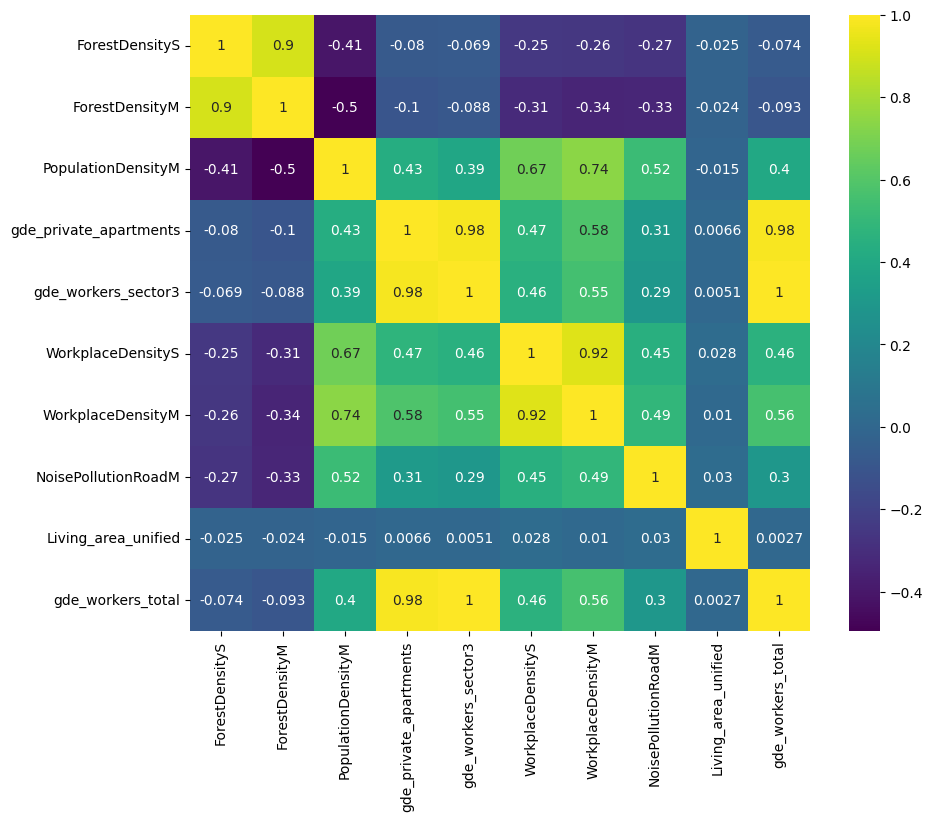

In [81]:
# correlation matrix highly_correlated_features
correlation_matrix = df_cleaned[highly_correlated_features].corr()

# plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.show()

# Model Preparation
Splitting the data into training and validation sets.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [58]:
# Identify categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Split the data into training and validation sets (80% train, 20% validation)
X = df_cleaned.drop(columns=['price_cleaned'])
y = df_cleaned['price_cleaned']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Update the list of numerical columns
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.difference(['price_cleaned'])

# Retry the preprocessing step with the updated list
# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the validation data
X_val_preprocessed = preprocessor.transform(X_val)

X_train_preprocessed.shape, X_val_preprocessed.shape

((17172, 53), (4294, 53))

# Model Selection

In [59]:
# Initialize and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_preprocessed, y_train)

# Predict on the validation set
y_val_pred = lr_model.predict(X_val_preprocessed)

# Evaluate the model's performance
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

mae, mse, r2

(565696.1077234641, 1989006130779.4062, 0.4372626477838111)

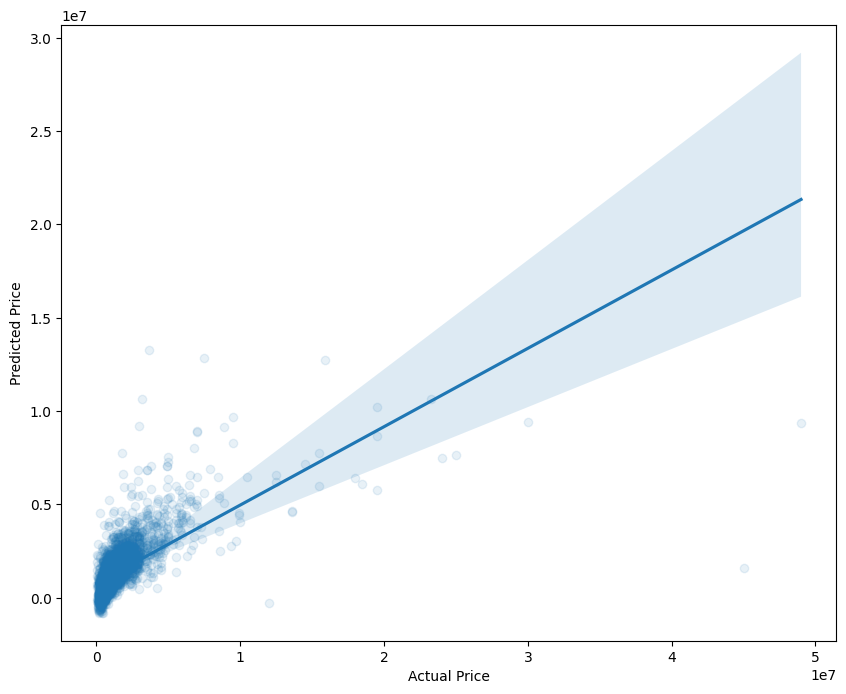

In [60]:
# plot
plt.figure(figsize=(10, 8))
sns.regplot(x=y_val, y=y_val_pred, scatter_kws={'alpha': 0.1})
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

## Residuen

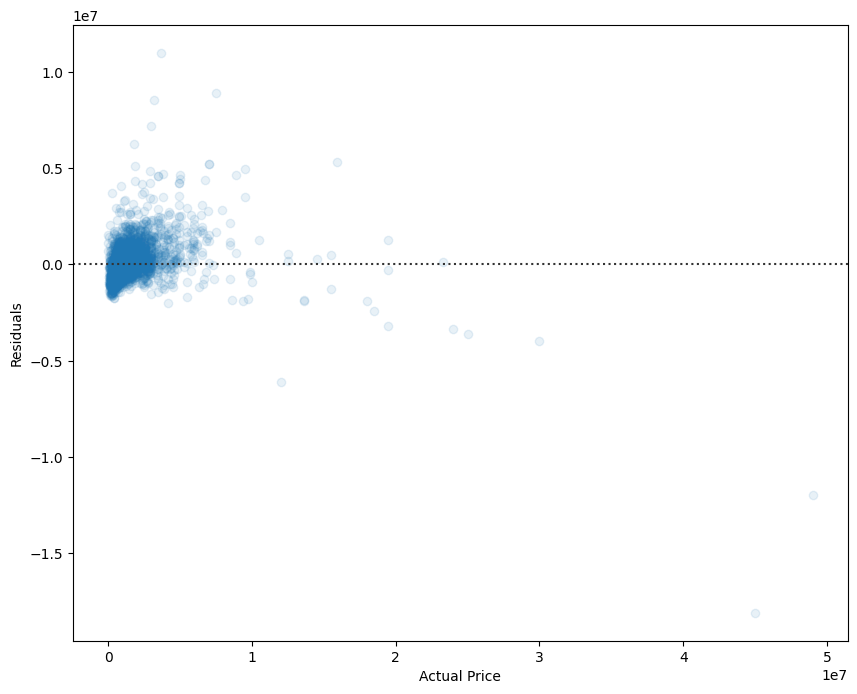

In [61]:
# residual plot
plt.figure(figsize=(10, 8))
sns.residplot(x=y_val, y=y_val_pred, scatter_kws={'alpha': 0.1})
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.show()

# Feature Engineering

In [82]:
df_numeric = df.select_dtypes(include=np.number)
df_numeric

,Unnamed: 0.1,Unnamed: 0,lat,lon,index,ForestDensityL,ForestDensityM,ForestDensityS,Latitude,Longitude,...,Plot_area_unified,Living_area_unified,No. of rooms:,Number of apartments:,Last refurbishment:,Year built:,Number of floors:,plz,Number of toilets:,space_cleaned
0,0,0,47.417100,8.085600,16620,0.511176,0.286451,0.090908,47.415927,8.085840,...,NaN,100.0,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN
1,1,1,47.419500,8.082700,16620,0.511176,0.286451,0.090908,47.415927,8.085840,...,222.0,156.0,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN
2,2,2,47.403300,8.033000,17812,0.163362,0.095877,0.001911,47.397416,8.043150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN
3,3,3,47.415643,8.085423,16620,0.511176,0.286451,0.090908,47.415927,8.085840,...,370.0,154.0,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN
4,4,4,47.403824,8.048288,12716,0.333865,0.279276,0.145835,47.404870,8.052781,...,NaN,142.0,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476,22476,29298,47.158318,9.468165,35362,0.495715,0.385885,0.097278,47.158311,9.468139,...,140.0,102.0,4.5,2.0,2021.0,1920.0,NaN,9470.0,NaN,102.0
22477,22477,29300,47.467488,9.052574,13921,0.000000,0.000000,0.000000,47.467888,9.052650,...,NaN,250.0,8.5,NaN,NaN,2022.0,3.0,9500.0,NaN,180.0
22478,22478,29301,47.465266,9.041548,14127,0.000000,0.000000,0.000000,47.463605,9.038485,...,455.0,240.0,8.5,1.0,2021.0,1966.0,3.0,9500.0,NaN,167.0
22479,22479,29302,47.526504,8.927411,10312,0.410843,0.151363,0.038351,47.526024,8.926627,...,NaN,175.0,5.5,NaN,NaN,2022.0,NaN,9548.0,NaN,175.0


In [83]:
# Check for missing values
missing_data = df_numeric.isnull().sum().sort_values(ascending=False)
missing_percentage = (df_numeric.isnull().sum() / df_numeric.shape[0]).sort_values(ascending=False) * 100

# Combine the results into a single DataFrame
missing_df = pd.concat([missing_data, missing_percentage], axis=1, keys=['Total Missing', 'Percentage (%)'])

# Display columns with missing data
missing_df[missing_df['Total Missing'] > 0]


,Total Missing,Percentage (%)
Number of toilets:,22408,99.675281
Number of apartments:,21577,95.978827
Last refurbishment:,20224,89.960411
Number of floors:,20082,89.328767
Year built:,15548,69.160625
Plot_area_unified,14528,64.623460
No. of rooms:,13613,60.553356
space_cleaned,13355,59.405720
gde_politics_pda,10827,48.160669
gde_politics_bdp,8780,39.055202


Several columns in the dataset have a significant amount of missing values. Here's a brief outline of our approach to handle them:

1. Columns with very high missing values (e.g., >80% missing): It may be best to drop these columns since imputing such a high percentage might introduce bias.
2. Target variable (price_search): Entries with missing target values should be removed since we can't train on or accurately impute these values.
3. Other columns with missing values: We'll consider imputation methods, which could include using the median, mean, or a model-based imputation.

In [84]:
# drop columns with more than 80% missing values
cols_to_drop = missing_df[missing_df['Percentage (%)'] > 80].index
df_cleaned = df_numeric.drop(columns=cols_to_drop)

# remove rows with missing values in price_cleaned
df_cleaned.dropna(subset=['price_cleaned'], inplace=True)

Next, we'll handle the missing values in the remaining columns. For numerical columns, we'll impute using the median (as it's less sensitive to outliers than the mean). For categorical columns, we'll use the mode.

In [85]:
# Separate numerical and categorical columns
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# Impute missing values
for col in numerical_cols:
    df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

for col in categorical_cols:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

# Check if there are any remaining missing values
remaining_missing = df_cleaned.isnull().sum().sum()
remaining_missing

0

# Model Selection

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

#### Linear Regression

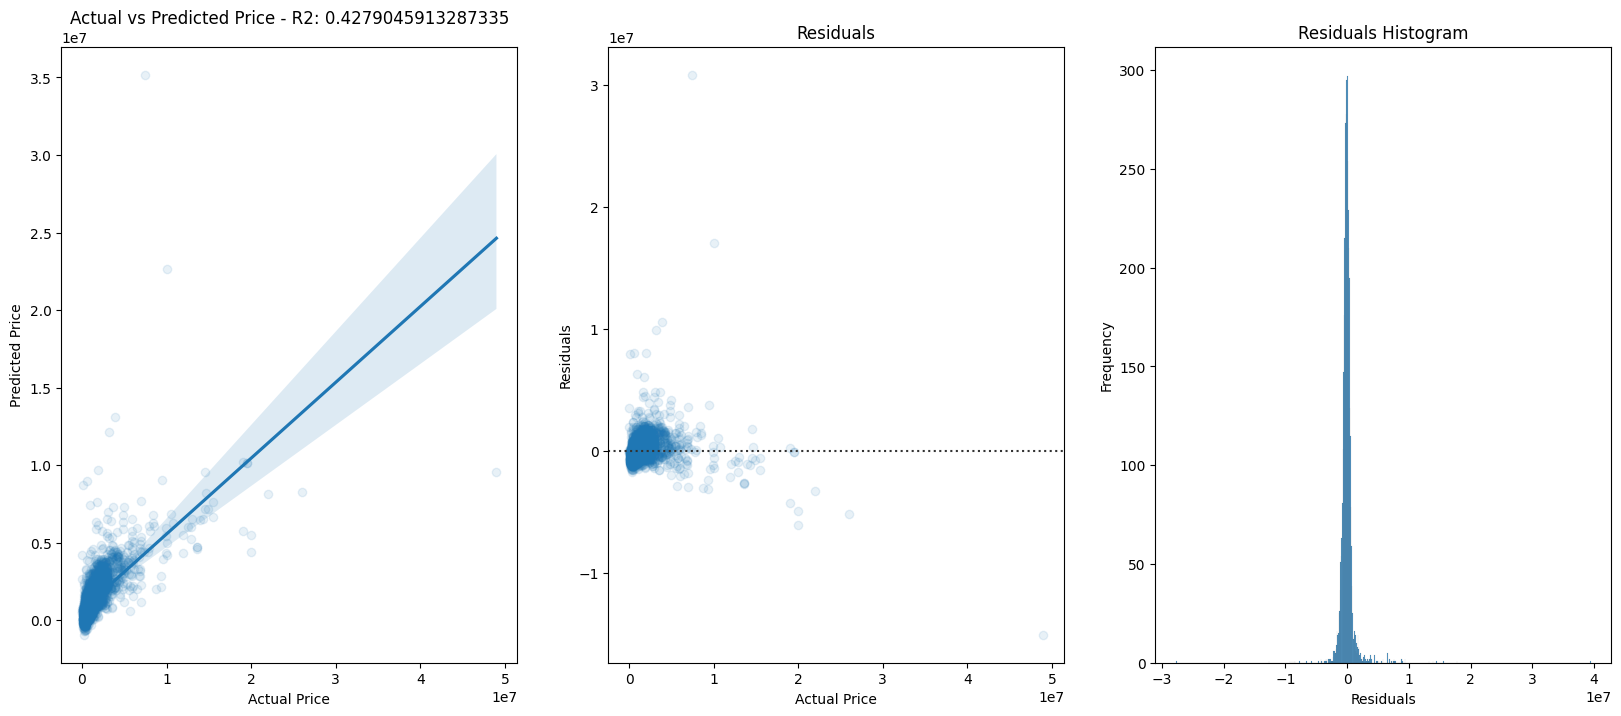

In [106]:
# create ml model based to predict price_cleaned, data = df_numeric
X = df_cleaned.drop('price_cleaned', axis=1)
y = df_cleaned['price_cleaned']

imputer = SimpleImputer(strategy='mean') # can also use 'median' or 'most_frequent' for mode
X = imputer.fit_transform(X)

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create linear regression model
lr = LinearRegression()

# fit model to training data
lr.fit(X_train, y_train)

# predict on test data
y_pred = lr.predict(X_test)

# calculate r2 score
r2 = r2_score(y_test, y_pred)

fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# actual vs predicted plot
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[0])
ax[0].set_title('Actual vs Predicted Price - R2: {}'.format(r2))
ax[0].set_xlabel('Actual Price')
ax[0].set_ylabel('Predicted Price')

# residuals plot
sns.residplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[1])
ax[1].set_title('Residuals')
ax[1].set_xlabel('Actual Price')
ax[1].set_ylabel('Residuals')

# histogram plot
sns.histplot((y_test - y_pred), ax=ax[2])
ax[2].set_title('Residuals Histogram')
ax[2].set_xlabel('Residuals')
ax[2].set_ylabel('Frequency')

plt.show()

#### Ridge

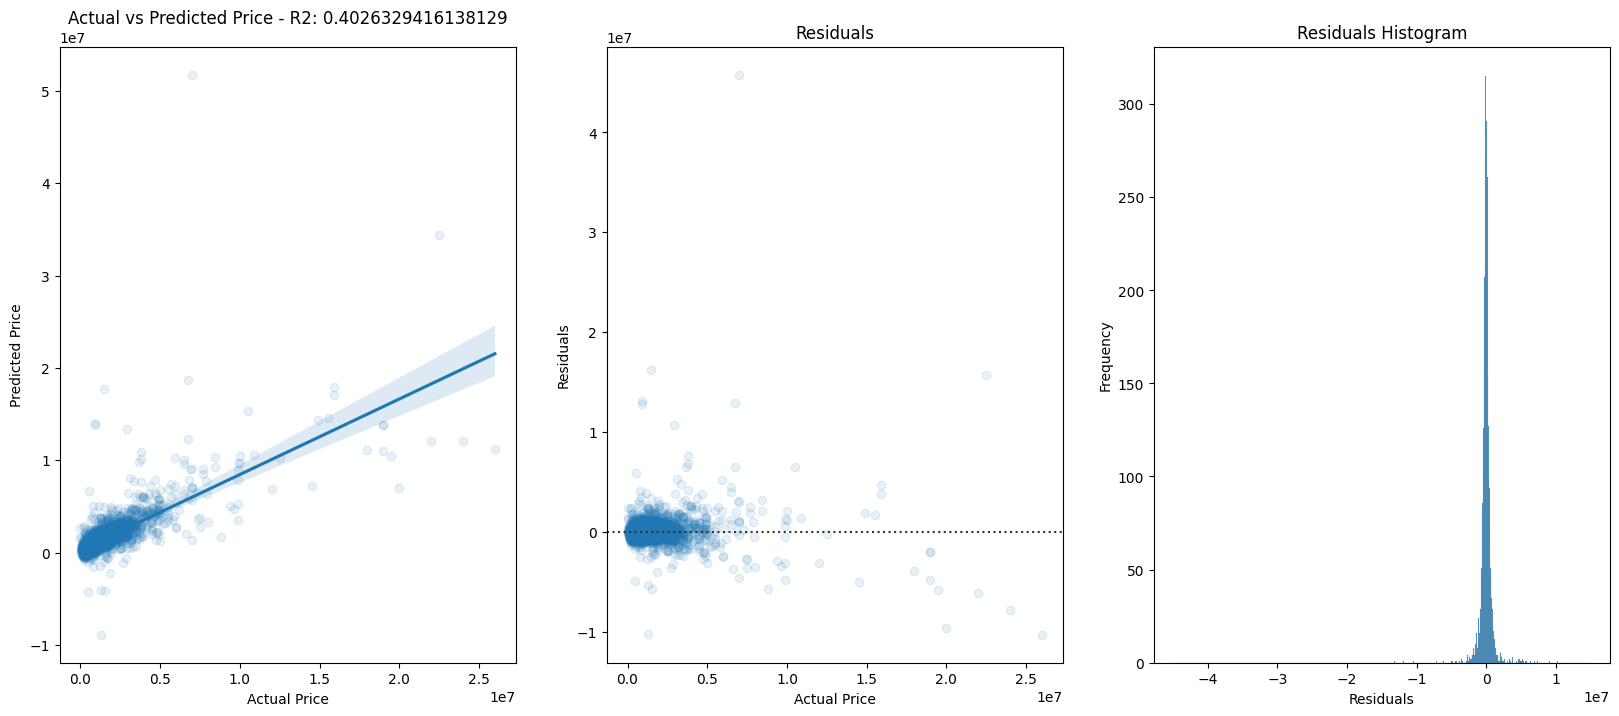

In [105]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

# Feature scaling and polynomial features
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)
y_pred_ridge = ridge.predict(X_test_poly)

# r2 score for ridge regression
r2_ridge = r2_score(y_test, y_pred_ridge)

# residuals plot and histogram plot side by side
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# actual vs predicted plot
sns.regplot(x=y_test, y=y_pred_ridge, scatter_kws={'alpha': 0.1}, ax=ax[0])
ax[0].set_title('Actual vs Predicted Price - R2: {}'.format(r2_ridge))
ax[0].set_xlabel('Actual Price')
ax[0].set_ylabel('Predicted Price')

# residuals plot
sns.residplot(x=y_test, y=y_pred_ridge, scatter_kws={'alpha': 0.1}, ax=ax[1])
ax[1].set_title('Residuals')
ax[1].set_xlabel('Actual Price')
ax[1].set_ylabel('Residuals')

# histogram plot
sns.histplot((y_test - y_pred_ridge), ax=ax[2])
ax[2].set_title('Residuals Histogram')
ax[2].set_xlabel('Residuals')
ax[2].set_ylabel('Frequency')

plt.show()

#### Random Forest

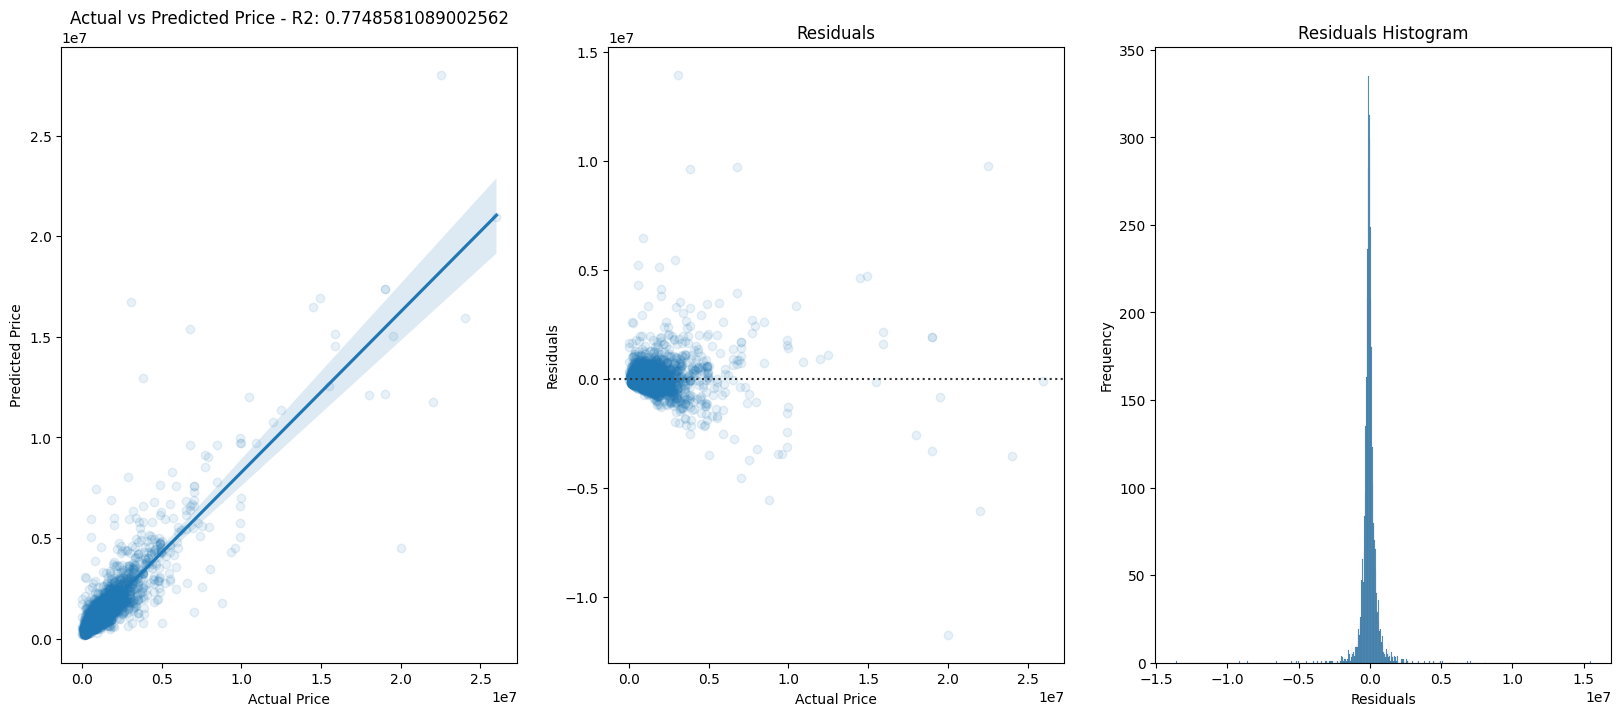

In [104]:
from sklearn.ensemble import RandomForestRegressor

# Create random forest regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Fit model to training data
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Calculate r2 score
r2_rf = r2_score(y_test, y_pred_rf)

# residuals plot and histogram plot side by side
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# actual vs predicted plot
sns.regplot(x=y_test, y=y_pred_rf, scatter_kws={'alpha': 0.1}, ax=ax[0])
ax[0].set_title('Actual vs Predicted Price - R2: {}'.format(r2_rf))
ax[0].set_xlabel('Actual Price')
ax[0].set_ylabel('Predicted Price')

# residuals plot
sns.residplot(x=y_test, y=y_pred_rf, scatter_kws={'alpha': 0.1}, ax=ax[1])
ax[1].set_title('Residuals')
ax[1].set_xlabel('Actual Price')
ax[1].set_ylabel('Residuals')

# histogram plot
sns.histplot((y_test - y_pred_rf), ax=ax[2])
ax[2].set_title('Residuals Histogram')
ax[2].set_xlabel('Residuals')
ax[2].set_ylabel('Frequency')

plt.show()